In [1]:
import pandas as pd
import numpy as np

import sys
import os
repo_root = os.path.abspath(os.path.join(os.getcwd(), "..", ".."))
sys.path.append(repo_root)

In [2]:
from src.traintest_split import train_test
inflow_train, inflow_test, outflow_train, outflow_test = train_test()

In [3]:
inflow_train['posted_date'] = pd.to_datetime(inflow_train['posted_date'], errors='coerce')
# it_sorted = inflow_train.sort_values(['prism_consumer_id', 'prism_account_id', 'posted_date'])
it_sorted = inflow_train.sort_values(['prism_consumer_id', 'posted_date'])
# it_sorted['interval'] = it_sorted.groupby('prism_consumer_id')['posted_date'].diff().dt.days
it_sorted['is_recurring_income'] = False

In [4]:
from src.income_recurrence import cluster_amounts, detect_recurring_transactions

# choose 1 acc form 1 consumer as test (change this when not restricting acc)
# test = it_sorted[(it_sorted['prism_consumer_id'] == 0)]

# form clusters
cluster_df = cluster_amounts(it_sorted)
# for each cluster: check recurrence 3x

# from joblib import Parallel, delayed

# def parallel_process_by_cluster(df, n_jobs=-1):
#     groups = [g for _, g in df.groupby("cluster_id")]
#     results = Parallel(n_jobs=n_jobs)(delayed(detect_recurring_transactions)(g) for g in groups)
#     return pd.concat(results).sort_index()

# income = parallel_process_by_cluster(cluster_df, n_jobs=-1)

In [5]:
from joblib import Parallel, delayed
import pandas as pd
import time

def process_one_consumer(df_sub):
    """
    df_sub = dataframe for ONE consumer (already filtered)
    Returns the same dataframe with recurring detection applied.
    """
    return detect_recurring_transactions(df_sub)


def parallel_process_by_consumer(df, n_jobs=-1, verbose=True):
    # Split into list of dataframes by consumer
    groups = [g for _, g in df.groupby("prism_consumer_id")]

    if verbose:
        print(f"Starting parallel processing for {len(groups)} consumers...")

    start = time.time()

    # Parallel execution
    results = Parallel(n_jobs=n_jobs)(
        delayed(process_one_consumer)(g) for g in groups
    )

    end = time.time()
    total_latency = end - start
    latency_per_consumer = total_latency / len(groups)

    if verbose:
        print("\n================ LATENCY REPORT ================")
        print(f"Total consumers processed: {len(groups)}")
        print(f"Wall-clock latency: {total_latency:.4f} seconds")
        print(f"Latency per consumer: {latency_per_consumer:.8f} seconds")
        print("================================================\n")
        
    print(total_latency)
    # Combine back together
    return pd.concat(results).sort_index()

In [6]:
income = parallel_process_by_consumer(cluster_df, n_jobs=-1)
income

Starting parallel processing for 2360 consumers...

================ LATENCY REPORT ================
Total consumers processed: 2360
Wall-clock latency: 6.9806 seconds
Latency per consumer: 0.00295789 seconds

6.980612516403198


,prism_consumer_id,prism_account_id,memo,amount,posted_date,category,is_recurring_income,cluster_id
0,0,acc_0,PAYCHECK,2477.02,2022-03-18,PAYCHECK,True,64
1,0,acc_0,EXTERNAL_TRANSFER,100.00,2022-10-25,EXTERNAL_TRANSFER,True,46
2,0,acc_0,MISCELLANEOUS,6.29,2022-08-26,MISCELLANEOUS,False,32
3,0,acc_0,EXTERNAL_TRANSFER,277.00,2022-06-03,EXTERNAL_TRANSFER,False,52
4,0,acc_0,EXTERNAL_TRANSFER,100.00,2022-07-29,EXTERNAL_TRANSFER,True,46
...,...,...,...,...,...,...,...,...
512373,5939,acc_9522,DEPOSIT,512.00,2022-12-05,DEPOSIT,True,55
512374,5939,acc_9522,REFUND,107.35,2022-12-13,REFUND,False,46
512375,5939,acc_9522,DEPOSIT,576.00,2023-01-03,DEPOSIT,False,56
512376,5939,acc_9522,DEPOSIT,95.34,2023-01-18,DEPOSIT,False,46


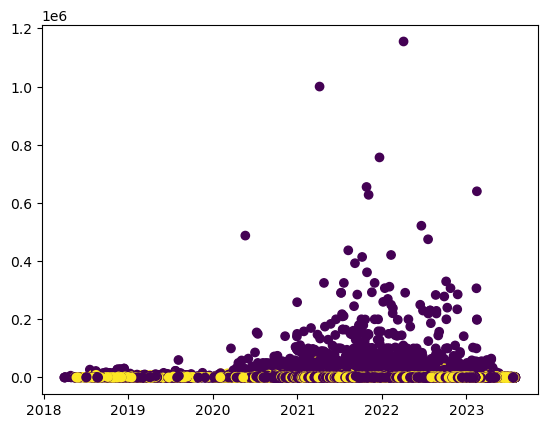

In [7]:
import matplotlib.pyplot as plt
plt.scatter(income['posted_date'], income['amount'], c=income['is_recurring_income'])

In [21]:
# true_income = income[income['is_recurring_income'] == True]
# plt.scatter(true_income['posted_date'], true_income['amount'], c=true_income['prism_consumer_id'])

In [8]:
income[income['is_recurring_income'] == True]

,prism_consumer_id,prism_account_id,memo,amount,posted_date,category,is_recurring_income,cluster_id
0,0,acc_0,PAYCHECK,2477.02,2022-03-18,PAYCHECK,True,64
1,0,acc_0,EXTERNAL_TRANSFER,100.00,2022-10-25,EXTERNAL_TRANSFER,True,46
4,0,acc_0,EXTERNAL_TRANSFER,100.00,2022-07-29,EXTERNAL_TRANSFER,True,46
5,0,acc_0,EXTERNAL_TRANSFER,100.00,2022-12-23,EXTERNAL_TRANSFER,True,46
6,0,acc_0,PAYCHECK,2547.35,2023-02-03,PAYCHECK,True,64
...,...,...,...,...,...,...,...,...
512365,5939,acc_9522,DEPOSIT,200.00,2022-09-15,DEPOSIT,True,50
512366,5939,acc_9522,DEPOSIT,508.00,2022-10-03,DEPOSIT,True,55
512368,5939,acc_9522,DEPOSIT,200.00,2022-10-17,DEPOSIT,True,50
512370,5939,acc_9522,DEPOSIT,548.00,2022-11-04,DEPOSIT,True,55


In [9]:
income[(income['category'] == 'PAYCHECK') | (income['category'] == 'PAYCHECK_PLACEHOLDER')]

,prism_consumer_id,prism_account_id,memo,amount,posted_date,category,is_recurring_income,cluster_id
0,0,acc_0,PAYCHECK,2477.02,2022-03-18,PAYCHECK,True,64
6,0,acc_0,PAYCHECK,2547.35,2023-02-03,PAYCHECK,True,64
16,0,acc_0,PAYCHECK,2528.40,2022-10-20,PAYCHECK,True,64
17,0,acc_0,PAYCHECK,2547.35,2023-01-20,PAYCHECK,True,64
25,0,acc_0,PAYCHECK,2331.71,2022-05-05,PAYCHECK,True,64
...,...,...,...,...,...,...,...,...
511989,5929,acc_9512,PAYCHECK,743.44,2022-12-28,PAYCHECK,True,57
511990,5929,acc_9512,PAYCHECK,728.89,2023-01-10,PAYCHECK,True,57
511992,5929,acc_9512,PAYCHECK,728.89,2023-01-24,PAYCHECK,True,57
512323,5939,acc_9522,PAYCHECK_PLACEHOLDER,76.75,2021-10-07,PAYCHECK_PLACEHOLDER,False,45


In [10]:
income[-20:]

,prism_consumer_id,prism_account_id,memo,amount,posted_date,category,is_recurring_income,cluster_id
512358,5939,acc_9522,DEPOSIT,200.00,2022-07-15,DEPOSIT,False,50
512359,5939,acc_9522,DEPOSIT,144.87,2022-07-20,DEPOSIT,False,48
512360,5939,acc_9522,DEPOSIT,245.00,2022-08-01,DEPOSIT,False,51
512361,5939,acc_9522,DEPOSIT,508.00,2022-08-03,DEPOSIT,True,55
512362,5939,acc_9522,DEPOSIT,200.00,2022-09-01,DEPOSIT,True,50
512363,5939,acc_9522,DEPOSIT,508.00,2022-09-02,DEPOSIT,True,55
512364,5939,acc_9522,MISCELLANEOUS,2.72,2022-09-06,MISCELLANEOUS,False,28
512365,5939,acc_9522,DEPOSIT,200.00,2022-09-15,DEPOSIT,True,50
512366,5939,acc_9522,DEPOSIT,508.00,2022-10-03,DEPOSIT,True,55
512367,5939,acc_9522,DEPOSIT,200.00,2022-10-03,DEPOSIT,False,50


In [15]:
income[income['is_recurring_income'] == True]['category'].value_counts().to_dict()

{'EXTERNAL_TRANSFER': 50039,
 'SELF_TRANSFER': 38589,
 'MISCELLANEOUS': 17751,
 'DEPOSIT': 16960,
 'PAYCHECK': 16487,
 'PAYCHECK_PLACEHOLDER': 12661,
 'SMALL_DOLLAR_ADVANCE': 7142,
 'REFUND': 5015,
 'OTHER_BENEFITS': 4829,
 'INVESTMENT_INCOME': 3961,
 'UNEMPLOYMENT_BENEFITS': 1244,
 'TAX': 1029,
 'LOAN': 874,
 'INSURANCE': 60}

In [13]:
income[income['is_recurring_income'] == False]['category'].value_counts()

category
EXTERNAL_TRANSFER        73386
SELF_TRANSFER            45931
DEPOSIT                  31286
MISCELLANEOUS            27234
REFUND                   13277
INVESTMENT_INCOME         9469
PAYCHECK                  9296
PAYCHECK_PLACEHOLDER      7898
SMALL_DOLLAR_ADVANCE      3794
TAX                       1659
OTHER_BENEFITS            1244
LOAN                      1058
UNEMPLOYMENT_BENEFITS      232
INSURANCE                   96
Name: count, dtype: int64

In [22]:
income[(income['is_recurring_income'] == False) & ((income['category'] == 'PAYCHECK') | (income['category'] == 'PAYCHECK_PLACEHOLDER'))]

,prism_consumer_id,prism_account_id,memo,amount,posted_date,category,is_recurring_income,cluster_id
48,0,acc_0,PAYCHECK_PLACEHOLDER,143.00,2022-07-11,PAYCHECK_PLACEHOLDER,False,48
85,0,acc_0,PAYCHECK,1093.54,2023-01-13,PAYCHECK,False,59
252,4,acc_5,PAYCHECK,10071.51,2022-12-23,PAYCHECK,False,72
272,4,acc_5,PAYCHECK_PLACEHOLDER,15.99,2022-03-25,PAYCHECK_PLACEHOLDER,False,37
310,4,acc_5,PAYCHECK,18571.63,2022-12-23,PAYCHECK,False,75
...,...,...,...,...,...,...,...,...
511966,5929,acc_9512,PAYCHECK,1073.26,2022-06-10,PAYCHECK,False,59
511973,5929,acc_9512,PAYCHECK,3030.92,2022-07-15,PAYCHECK,False,65
511974,5929,acc_9512,PAYCHECK,330.32,2022-07-25,PAYCHECK,False,53
512323,5939,acc_9522,PAYCHECK_PLACEHOLDER,76.75,2021-10-07,PAYCHECK_PLACEHOLDER,False,45
